<a href="https://colab.research.google.com/github/DCaraxess/Sistemas-Operativos-tarea2/blob/main/SistemasOperativos2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# scheduling_simulator.py

import matplotlib.pyplot as plt
import numpy as np
from collections import deque
import copy
import itertools
import math

=== COMPARACIÓN CON ORDEN ORIGINAL DE PROCESOS ===

--- Tiempo de Servicio (Turnaround Time) ---
Proceso	FCFS	HRRN	SJF	SRT	RR
P1	10	10	10	10	26
P2	39	63	63	63	63
P3	52	23	31	31	47
P4	53	24	8	8	24
Promedio	38.50	30.00	28.00	28.00	40.00

--- Tiempo de Espera (Waiting Time) ---
Proceso	FCFS	HRRN	SJF	SRT	RR
P1	0	0	0	0	16
P2	10	34	34	34	34
P3	36	7	15	15	31
P4	45	16	0	0	16
Promedio	22.75	14.25	12.25	12.25	24.25

--- Índice de Servicio (Service Index) ---
Proceso	FCFS	HRRN	SJF	SRT	RR
P1	1.00	1.00	1.00	1.00	0.38
P2	0.74	0.46	0.46	0.46	0.46
P3	0.31	0.70	0.52	0.52	0.34
P4	0.15	0.33	1.00	1.00	0.33
Promedio	0.55	0.62	0.74	0.74	0.38

=== COMPARACIÓN CON TODAS LAS 24 PERMUTACIONES ===
Total permutations: 24
Testing permutation 1: P1 → P2 → P3 → P4
Testing permutation 2: P1 → P2 → P4 → P3
Testing permutation 3: P1 → P3 → P2 → P4
Testing permutation 4: P1 → P3 → P4 → P2
Testing permutation 5: P1 → P4 → P2 → P3
Testing permutation 6: P1 → P4 → P3 → P2
Testing permutation 7: P2 → P1 → P3 → P4
Testing pe

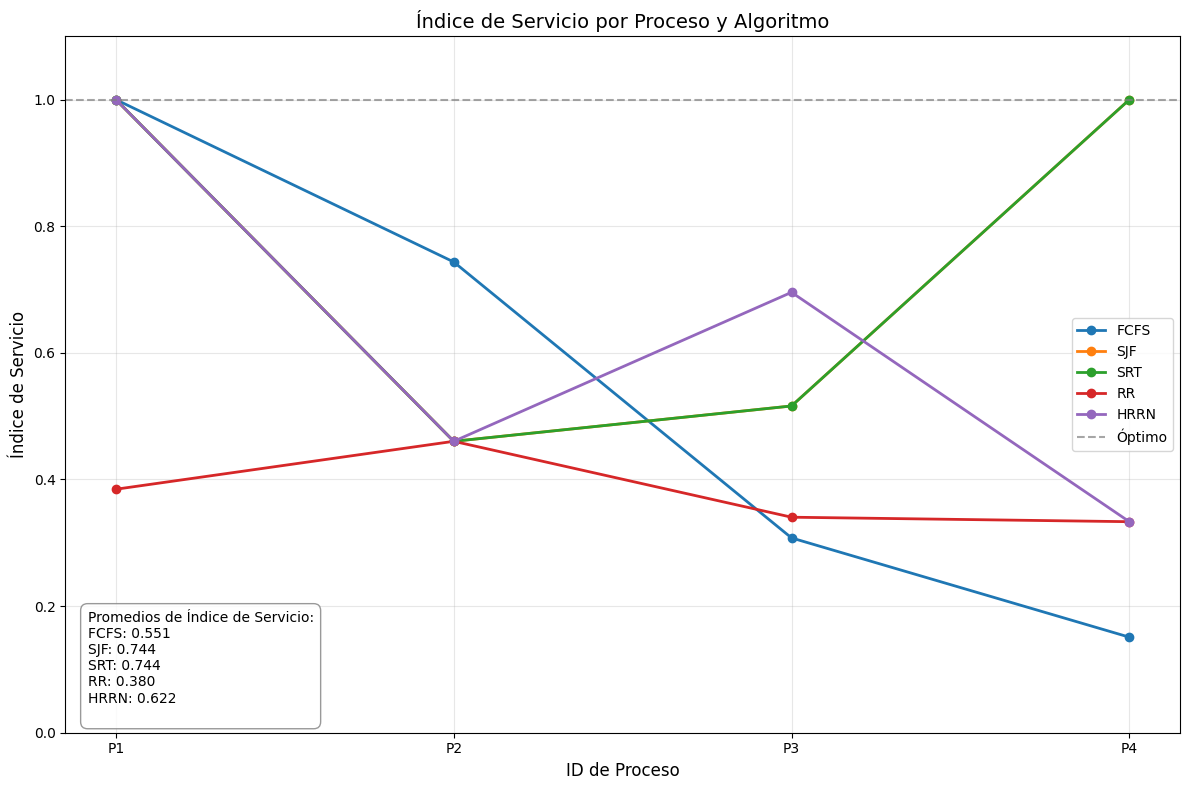

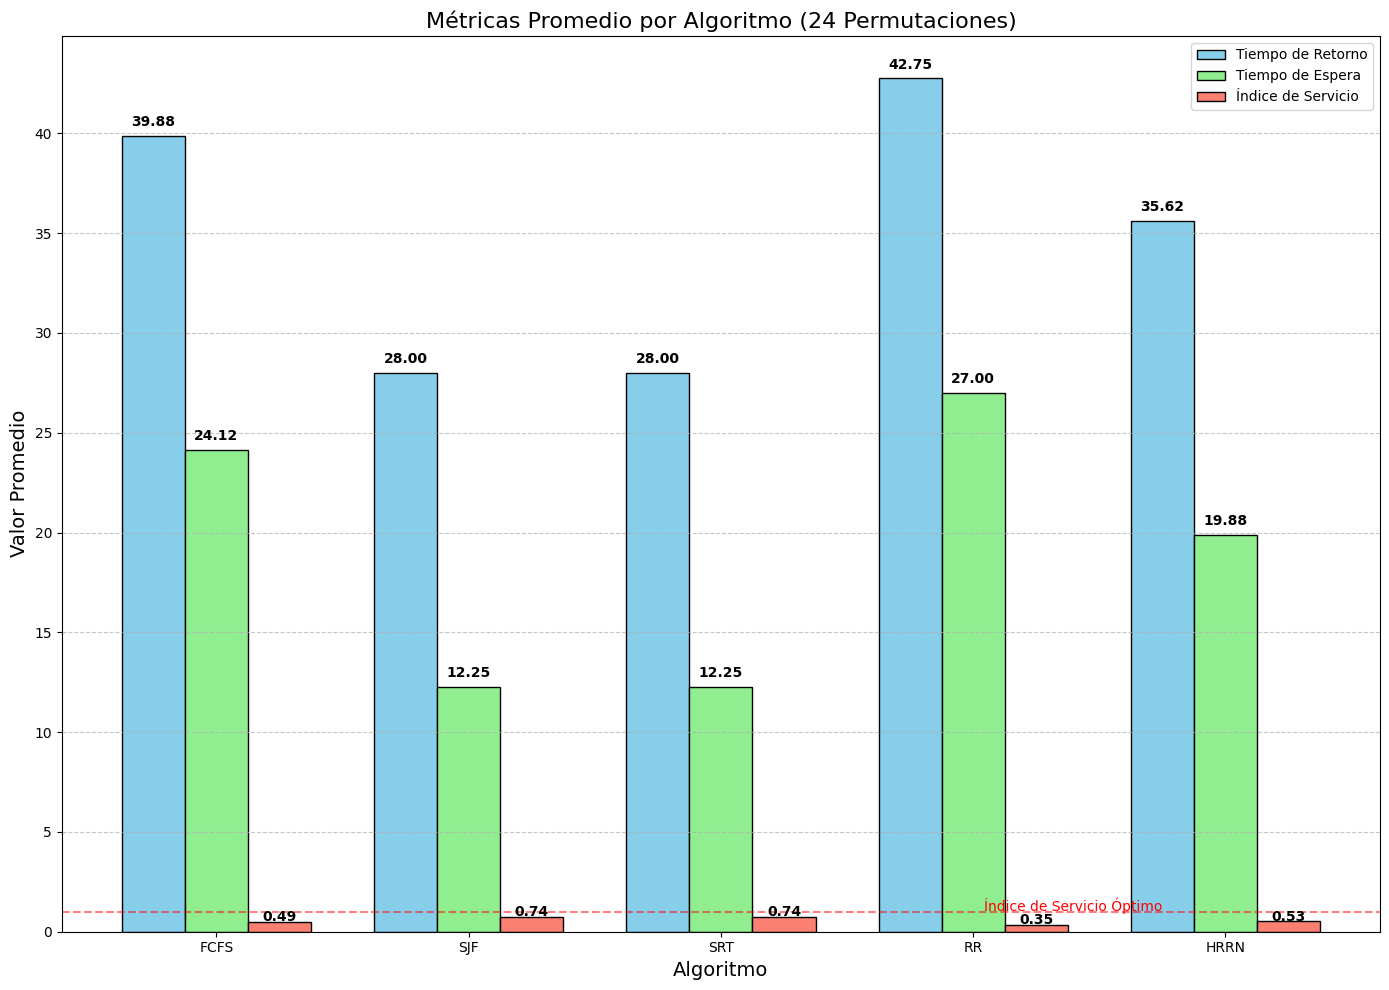

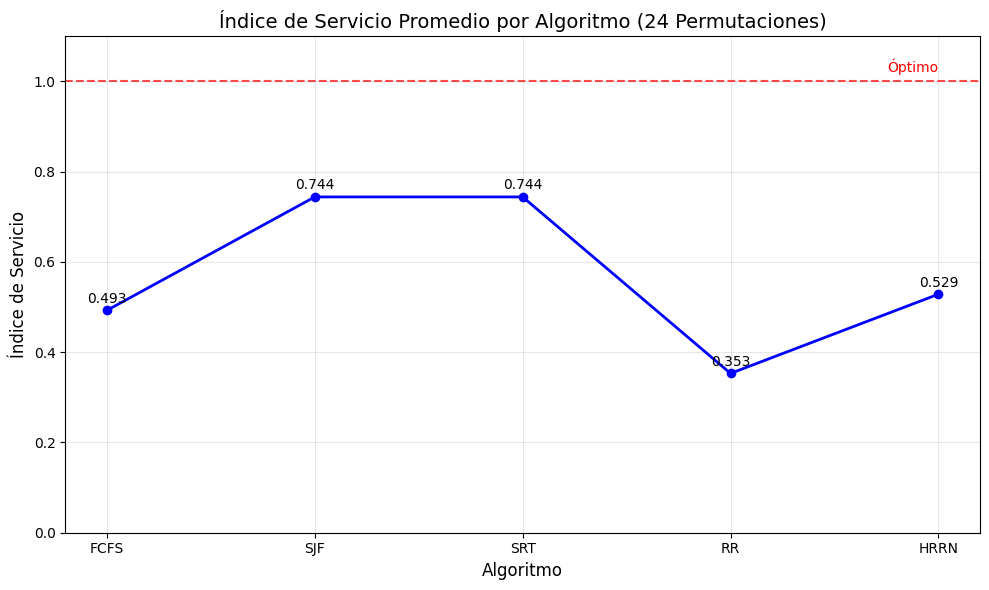

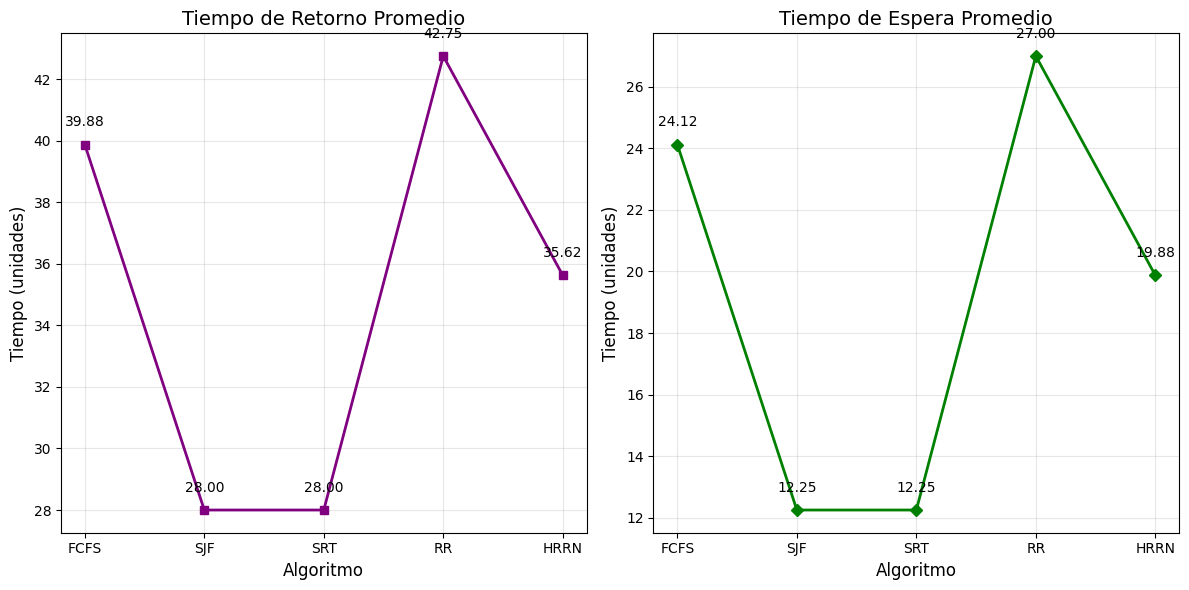

In [10]:

class Process:
    def __init__(self, pid, arrival_time, burst_time):
        self.pid = pid
        self.arrival_time = arrival_time
        self.burst_time = burst_time
        self.remaining_time = burst_time
        self.start_time = None
        self.completion_time = None
        self.waiting_time = 0
        self.turnaround_time = 0
        self.service_index = 0
        self.executed = False
        self.execution_history = []
        # Para resolver empates en el orden
        self.original_position = pid

    def __str__(self):
        return f"P{self.pid}"

    def reset(self):
        self.remaining_time = self.burst_time
        self.start_time = None
        self.completion_time = None
        self.waiting_time = 0
        self.turnaround_time = 0
        self.service_index = 0
        self.executed = False
        self.execution_history = []

class CPUScheduler:
    def __init__(self):
        self.processes = []
        self.timeline = []
        self.current_time = 0
        self.gantt_chart = []

    def add_process(self, pid, arrival_time, burst_time):
        self.processes.append(Process(pid, arrival_time, burst_time))

    def reset_processes(self):
        for process in self.processes:
            process.reset()
        self.timeline = []
        self.current_time = 0
        self.gantt_chart = []

    def set_processes(self, processes):
        self.processes = processes

    def fcfs(self):
        """First Come First Serve scheduler"""
        self.reset_processes()
        ready_queue = deque()
        processes = sorted(self.processes, key=lambda p: p.arrival_time)

        while processes or ready_queue:
            # Agrupar procesos por tiempo de llegada
            current_arrival_time = self.current_time if not processes else processes[0].arrival_time
            arrival_group = []

            while processes and processes[0].arrival_time <= self.current_time:
                arrival_group.append(processes.pop(0))

            # Si no hay procesos en cola pero hay más por llegar, avanzar tiempo
            if not arrival_group and not ready_queue and processes:
                self.current_time = processes[0].arrival_time
                continue

            # Ordenar procesos que llegan al mismo tiempo por posición original
            if arrival_group:
                arrival_group.sort(key=lambda p: p.original_position)
                for process in arrival_group:
                    ready_queue.append(process)

            if not ready_queue:
                continue

            current_process = ready_queue.popleft()

            # Si el proceso no ha comenzado aún
            if current_process.start_time is None:
                current_process.start_time = self.current_time

            # Ejecutar el proceso completo
            self.gantt_chart.append((str(current_process), self.current_time, self.current_time + current_process.remaining_time))
            self.current_time += current_process.remaining_time
            current_process.completion_time = self.current_time
            current_process.turnaround_time = current_process.completion_time - current_process.arrival_time
            current_process.waiting_time = current_process.turnaround_time - current_process.burst_time
            current_process.service_index = current_process.burst_time / current_process.turnaround_time
            current_process.remaining_time = 0

    def sjf(self):
        """Shortest Job First (non-preemptive) scheduler that respects permutation order"""
        self.reset_processes()
        ready_queue = []
        processes = sorted(self.processes, key=lambda p: p.arrival_time)

        while processes or ready_queue:
            # Agrupar procesos por tiempo de llegada
            arrival_group = []

            while processes and processes[0].arrival_time <= self.current_time:
                arrival_group.append(processes.pop(0))

            # Si no hay procesos en cola pero hay más por llegar, avanzar tiempo
            if not arrival_group and not ready_queue and processes:
                self.current_time = processes[0].arrival_time
                continue

            # Ordenar procesos que llegan al mismo tiempo por posición original
            if arrival_group:
                arrival_group.sort(key=lambda p: p.original_position)
                ready_queue.extend(arrival_group)

            if not ready_queue:
                continue

            # Encontrar el trabajo más corto en la cola
            shortest_idx = 0
            for i in range(1, len(ready_queue)):
                if ready_queue[i].burst_time < ready_queue[shortest_idx].burst_time:
                    shortest_idx = i

            current_process = ready_queue.pop(shortest_idx)

            # Si el proceso no ha comenzado aún
            if current_process.start_time is None:
                current_process.start_time = self.current_time

            # Ejecutar el proceso completo
            self.gantt_chart.append((str(current_process), self.current_time, self.current_time + current_process.remaining_time))
            self.current_time += current_process.remaining_time
            current_process.completion_time = self.current_time
            current_process.turnaround_time = current_process.completion_time - current_process.arrival_time
            current_process.waiting_time = current_process.turnaround_time - current_process.burst_time
            current_process.service_index = current_process.burst_time / current_process.turnaround_time
            current_process.remaining_time = 0

    def srt(self):
        """Shortest Remaining Time (preemptive) scheduler respecting permutation order"""
        self.reset_processes()
        ready_queue = []
        processes = sorted(self.processes, key=lambda p: p.arrival_time)
        completed = 0

        while completed < len(self.processes):
            # Agrupar procesos por tiempo de llegada
            arrival_group = []

            while processes and processes[0].arrival_time <= self.current_time:
                arrival_group.append(processes.pop(0))

            # Ordenar procesos que llegan al mismo tiempo por posición original
            if arrival_group:
                arrival_group.sort(key=lambda p: p.original_position)
                ready_queue.extend(arrival_group)

            if not ready_queue:
                # CPU idle hasta próxima llegada
                if processes:
                    self.current_time = processes[0].arrival_time
                    continue
                else:
                    break

            # Encontrar el proceso con menor tiempo restante
            shortest_idx = 0
            for i in range(1, len(ready_queue)):
                if ready_queue[i].remaining_time < ready_queue[shortest_idx].remaining_time:
                    shortest_idx = i
                # En caso de empate en tiempo restante, usar posición original
                elif ready_queue[i].remaining_time == ready_queue[shortest_idx].remaining_time:
                    if ready_queue[i].original_position < ready_queue[shortest_idx].original_position:
                        shortest_idx = i

            current_process = ready_queue[shortest_idx]

            # Si el proceso no ha comenzado aún
            if current_process.start_time is None:
                current_process.start_time = self.current_time

            # Calcular tiempo hasta próxima llegada o finalización
            time_slice = current_process.remaining_time
            next_event_time = float('inf')

            if processes:
                next_event_time = processes[0].arrival_time

            if next_event_time > self.current_time and next_event_time < self.current_time + time_slice:
                time_slice = next_event_time - self.current_time

            # Ejecutar proceso por time_slice
            self.gantt_chart.append((str(current_process), self.current_time, self.current_time + time_slice))
            self.current_time += time_slice
            current_process.remaining_time -= time_slice

            # Si el proceso ha terminado
            if current_process.remaining_time <= 0:
                ready_queue.pop(shortest_idx)
                current_process.completion_time = self.current_time
                current_process.turnaround_time = current_process.completion_time - current_process.arrival_time
                current_process.waiting_time = current_process.turnaround_time - current_process.burst_time
                current_process.service_index = current_process.burst_time / current_process.turnaround_time
                completed += 1

    def round_robin(self, quantum):
        """Round Robin scheduler with specified quantum, respecting permutation order"""
        self.reset_processes()
        ready_queue = deque()
        processes = sorted(self.processes, key=lambda p: p.arrival_time)
        completed = 0

        while completed < len(self.processes):
            # Agrupar procesos por tiempo de llegada
            arrival_group = []

            while processes and processes[0].arrival_time <= self.current_time:
                arrival_group.append(processes.pop(0))

            # Ordenar procesos que llegan al mismo tiempo por posición original
            if arrival_group:
                arrival_group.sort(key=lambda p: p.original_position)
                for process in arrival_group:
                    ready_queue.append(process)

            if not ready_queue:
                # CPU idle hasta próxima llegada
                if processes:
                    self.current_time = processes[0].arrival_time
                    continue
                else:
                    break

            current_process = ready_queue.popleft()

            # Si el proceso no ha comenzado aún
            if current_process.start_time is None:
                current_process.start_time = self.current_time

            # Ejecutar proceso por quantum o hasta finalización
            time_slice = min(quantum, current_process.remaining_time)
            self.gantt_chart.append((str(current_process), self.current_time, self.current_time + time_slice))
            self.current_time += time_slice
            current_process.remaining_time -= time_slice

            # Añadir nuevas llegadas durante ejecución
            new_arrivals = []
            while processes and processes[0].arrival_time <= self.current_time:
                new_arrivals.append(processes.pop(0))

            # Ordenar nuevas llegadas por posición original
            if new_arrivals:
                new_arrivals.sort(key=lambda p: p.original_position)
                for process in new_arrivals:
                    ready_queue.append(process)

            # Si el proceso ha terminado
            if current_process.remaining_time <= 0:
                current_process.completion_time = self.current_time
                current_process.turnaround_time = current_process.completion_time - current_process.arrival_time
                current_process.waiting_time = current_process.turnaround_time - current_process.burst_time
                current_process.service_index = current_process.burst_time / current_process.turnaround_time
                completed += 1
            else:
                # Si no terminó, devolver a la cola
                ready_queue.append(current_process)

    def hrrn(self):
        """Highest Response Ratio Next scheduler respecting permutation order"""
        self.reset_processes()
        ready_queue = []
        processes = sorted(self.processes, key=lambda p: p.arrival_time)

        while processes or ready_queue:
            # Agrupar procesos por tiempo de llegada
            arrival_group = []

            while processes and processes[0].arrival_time <= self.current_time:
                arrival_group.append(processes.pop(0))

            # Ordenar procesos que llegan al mismo tiempo por posición original
            if arrival_group:
                arrival_group.sort(key=lambda p: p.original_position)
                ready_queue.extend(arrival_group)

            if not ready_queue:
                # CPU idle hasta próxima llegada
                if processes:
                    self.current_time = processes[0].arrival_time
                    continue
                else:
                    break

            # Calcular ratio de respuesta para cada proceso
            max_ratio = -1
            selected_idx = 0

            for i, process in enumerate(ready_queue):
                waiting_time = self.current_time - process.arrival_time
                response_ratio = (waiting_time + process.burst_time) / process.burst_time
                process.response_ratio = response_ratio

                # Seleccionar mayor ratio, desempatar por posición original
                if response_ratio > max_ratio or (response_ratio == max_ratio and
                                                process.original_position < ready_queue[selected_idx].original_position):
                    max_ratio = response_ratio
                    selected_idx = i

            current_process = ready_queue.pop(selected_idx)

            # Si el proceso no ha comenzado aún
            if current_process.start_time is None:
                current_process.start_time = self.current_time

            # Ejecutar el proceso completo
            self.gantt_chart.append((str(current_process), self.current_time, self.current_time + current_process.remaining_time))
            self.current_time += current_process.remaining_time
            current_process.completion_time = self.current_time
            current_process.turnaround_time = current_process.completion_time - current_process.arrival_time
            current_process.waiting_time = current_process.turnaround_time - current_process.burst_time
            current_process.service_index = current_process.burst_time / current_process.turnaround_time
            current_process.remaining_time = 0

    def get_results(self):
        """Return metrics for all processes"""
        results = []
        for process in self.processes:
            results.append({
                'pid': process.pid,
                'arrival_time': process.arrival_time,
                'burst_time': process.burst_time,
                'completion_time': process.completion_time,
                'turnaround_time': process.turnaround_time,
                'waiting_time': process.waiting_time,
                'service_index': process.service_index
            })
        return results

    def get_average_metrics(self):
        """Calculate average metrics"""
        total_turnaround = sum(p.turnaround_time for p in self.processes)
        total_waiting = sum(p.waiting_time for p in self.processes)
        total_service_index = sum(p.service_index for p in self.processes)
        n = len(self.processes)

        return {
            'avg_turnaround': total_turnaround / n,
            'avg_waiting': total_waiting / n,
            'avg_service_index': total_service_index / n
        }

def run_permutation_comparison():
    """Run comparison across all 24 permutations of the 4 processes"""
    # Define base processes with fixed characteristics
    base_processes_data = [
        (1, 0, 10),   # P1: (pid, arrival_time, burst_time)
        (2, 0, 29),   # P2
        (3, 3, 16),   # P3
        (4, 10, 8)    # P4
    ]

    # Generate all possible permutations of the order in which processes are considered
    process_positions = list(range(4))  # 0, 1, 2, 3 representing positions
    position_permutations = list(itertools.permutations(process_positions))

    print(f"Total permutations: {len(position_permutations)}")

    # Dictionary to store results for each algorithm across all permutations
    all_results = {
        'FCFS': [],
        'SJF': [],
        'SRT': [],
        'RR': [],
        'HRRN': []
    }

    # Create scheduler
    scheduler = CPUScheduler()

    # Store permutation details for reference
    permutation_details = []

    # Test each permutation
    for i, positions in enumerate(position_permutations):
        # Create process list for this permutation
        processes = []

        # Map position permutation to processes
        perm_str_parts = []
        for pos, idx in enumerate(positions):
            pid, arrival_time, burst_time = base_processes_data[idx]
            # Create process with original data but set original_position according to permutation
            process = Process(pid, arrival_time, burst_time)
            process.original_position = pos  # Position in this permutation - used for tie-breaking
            processes.append(process)
            perm_str_parts.append(f"P{pid}")

        perm_str = " → ".join(perm_str_parts)
        permutation_details.append(perm_str)
        print(f"Testing permutation {i+1}: {perm_str}")

        # Run FCFS
        scheduler.set_processes(copy.deepcopy(processes))
        scheduler.fcfs()
        all_results['FCFS'].append({
            'permutation': perm_str,
            'metrics': scheduler.get_results(),
            'avg_metrics': scheduler.get_average_metrics()
        })

        # Run SJF
        scheduler.set_processes(copy.deepcopy(processes))
        scheduler.sjf()
        all_results['SJF'].append({
            'permutation': perm_str,
            'metrics': scheduler.get_results(),
            'avg_metrics': scheduler.get_average_metrics()
        })

        # Run SRT
        scheduler.set_processes(copy.deepcopy(processes))
        scheduler.srt()
        all_results['SRT'].append({
            'permutation': perm_str,
            'metrics': scheduler.get_results(),
            'avg_metrics': scheduler.get_average_metrics()
        })

        # Run RR
        scheduler.set_processes(copy.deepcopy(processes))
        scheduler.round_robin(8)
        all_results['RR'].append({
            'permutation': perm_str,
            'metrics': scheduler.get_results(),
            'avg_metrics': scheduler.get_average_metrics()
        })

        # Run HRRN
        scheduler.set_processes(copy.deepcopy(processes))
        scheduler.hrrn()
        all_results['HRRN'].append({
            'permutation': perm_str,
            'metrics': scheduler.get_results(),
            'avg_metrics': scheduler.get_average_metrics()
        })

    # Calculate averages across all permutations
    avg_results = {}
    for algo, perms in all_results.items():
        total_turnaround = 0
        total_waiting = 0
        total_service_index = 0

        for perm in perms:
            total_turnaround += perm['avg_metrics']['avg_turnaround']
            total_waiting += perm['avg_metrics']['avg_waiting']
            total_service_index += perm['avg_metrics']['avg_service_index']

        n = len(perms)
        avg_results[algo] = {
            'avg_turnaround': total_turnaround / n,
            'avg_waiting': total_waiting / n,
            'avg_service_index': total_service_index / n
        }

    # Print the results tables
    print("\n--- Tiempo de Servicio (Turnaround Time) Promedio por Permutación ---")
    print("Algoritmo\tPromedio de todas las permutaciones")
    for algo, metrics in avg_results.items():
        print(f"{algo}\t{metrics['avg_turnaround']:.2f}")

    print("\n--- Tiempo de Espera (Waiting Time) Promedio por Permutación ---")
    print("Algoritmo\tPromedio de todas las permutaciones")
    for algo, metrics in avg_results.items():
        print(f"{algo}\t{metrics['avg_waiting']:.2f}")

    print("\n--- Índice de Servicio (Service Index) Promedio por Permutación ---")
    print("Algoritmo\tPromedio de todas las permutaciones")
    for algo, metrics in avg_results.items():
        print(f"{algo}\t{metrics['avg_service_index']:.2f}")

    # Create comparison chart for average metrics
    create_permutation_comparison_chart(avg_results)

    # Find best and worst permutations for each algorithm
    for algo, perms in all_results.items():
        print(f"\n--- {algo} - Mejores y Peores Permutaciones ---")

        # Verify if there are differences between permutations
        waiting_times = [p['avg_metrics']['avg_waiting'] for p in perms]
        max_diff = max(waiting_times) - min(waiting_times)

        if max_diff < 0.01:  # Si la diferencia es muy pequeña, se consideran iguales
            print(f"Todas las permutaciones dan prácticamente el mismo resultado para {algo}.")
            sample_perm = perms[0]
            print(f"Tiempo de espera promedio: {sample_perm['avg_metrics']['avg_waiting']:.2f}")
            print(f"Tiempo de servicio promedio: {sample_perm['avg_metrics']['avg_turnaround']:.2f}")
            print(f"Índice de servicio promedio: {sample_perm['avg_metrics']['avg_service_index']:.2f}")
        else:
            # There are differences, show best and worst
            best_perm = min(perms, key=lambda x: x['avg_metrics']['avg_waiting'])
            print(f"Mejor permutación: {best_perm['permutation']}")
            print(f"  Tiempo de espera promedio: {best_perm['avg_metrics']['avg_waiting']:.2f}")
            print(f"  Tiempo de servicio promedio: {best_perm['avg_metrics']['avg_turnaround']:.2f}")
            print(f"  Índice de servicio promedio: {best_perm['avg_metrics']['avg_service_index']:.2f}")

            worst_perm = max(perms, key=lambda x: x['avg_metrics']['avg_waiting'])
            print(f"Peor permutación: {worst_perm['permutation']}")
            print(f"  Tiempo de espera promedio: {worst_perm['avg_metrics']['avg_waiting']:.2f}")
            print(f"  Tiempo de servicio promedio: {worst_perm['avg_metrics']['avg_turnaround']:.2f}")
            print(f"  Índice de servicio promedio: {worst_perm['avg_metrics']['avg_service_index']:.2f}")

    return all_results, avg_results, permutation_details

def create_permutation_comparison_chart(avg_results):
    """Create charts comparing average metrics across all permutations for each algorithm"""
    algorithms = list(avg_results.keys())

    # Create figure for bar chart comparison
    plt.figure(figsize=(14, 10))

    # Width of bars and positions
    bar_width = 0.25
    r1 = np.arange(len(algorithms))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    # Create bars for each metric
    plt.bar(r1, [avg_results[algo]['avg_turnaround'] for algo in algorithms],
            width=bar_width, color='skyblue', edgecolor='black', label='Tiempo de Retorno')

    plt.bar(r2, [avg_results[algo]['avg_waiting'] for algo in algorithms],
            width=bar_width, color='lightgreen', edgecolor='black', label='Tiempo de Espera')

    plt.bar(r3, [avg_results[algo]['avg_service_index'] for algo in algorithms],
            width=bar_width, color='salmon', edgecolor='black', label='Índice de Servicio')

    # Add values on top of bars
    for i, algo in enumerate(algorithms):
        plt.text(r1[i], avg_results[algo]['avg_turnaround'] + 0.5,
                f"{avg_results[algo]['avg_turnaround']:.2f}",
                ha='center', fontweight='bold')

        plt.text(r2[i], avg_results[algo]['avg_waiting'] + 0.5,
                f"{avg_results[algo]['avg_waiting']:.2f}",
                ha='center', fontweight='bold')

        plt.text(r3[i], avg_results[algo]['avg_service_index'] + 0.02,
                f"{avg_results[algo]['avg_service_index']:.2f}",
                ha='center', fontweight='bold')

    # Set chart properties
    plt.title('Métricas Promedio por Algoritmo (24 Permutaciones)', fontsize=16)
    plt.xlabel('Algoritmo', fontsize=14)
    plt.ylabel('Valor Promedio', fontsize=14)
    plt.xticks([r + bar_width for r in range(len(algorithms))], algorithms)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add horizontal line at y=1 for optimal service index
    plt.axhline(y=1, color='red', linestyle='--', alpha=0.5)
    plt.text(len(algorithms)-1, 1.02, 'Índice de Servicio Óptimo',
             color='red', ha='right', fontsize=10)

    plt.tight_layout()
    plt.savefig('algorithm_metrics_comparison.png')

    # Create separate chart just for service index
    plt.figure(figsize=(10, 6))
    plt.plot(algorithms, [avg_results[algo]['avg_service_index'] for algo in algorithms],
            marker='o', linewidth=2, color='blue')

    # Add values above points
    for i, algo in enumerate(algorithms):
        plt.text(i, avg_results[algo]['avg_service_index'] + 0.01,
                f"{avg_results[algo]['avg_service_index']:.3f}",
                ha='center', va='bottom')

    # Add horizontal line at y=1
    plt.axhline(y=1, color='red', linestyle='--', alpha=0.7)
    plt.text(len(algorithms)-1, 1.02, 'Óptimo', color='red', ha='right')

    # Set chart properties
    plt.title('Índice de Servicio Promedio por Algoritmo (24 Permutaciones)', fontsize=14)
    plt.xlabel('Algoritmo', fontsize=12)
    plt.ylabel('Índice de Servicio', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1.1)

    plt.tight_layout()
    plt.savefig('service_index_comparison.png')

    # Create chart for turnaround and waiting times
    plt.figure(figsize=(12, 6))

    # Plot turnaround times
    plt.subplot(1, 2, 1)
    plt.plot(algorithms, [avg_results[algo]['avg_turnaround'] for algo in algorithms],
             marker='s', linewidth=2, color='purple')

    for i, algo in enumerate(algorithms):
        plt.text(i, avg_results[algo]['avg_turnaround'] + 0.5,
                f"{avg_results[algo]['avg_turnaround']:.2f}",
                ha='center', va='bottom')

    plt.title('Tiempo de Retorno Promedio', fontsize=14)
    plt.xlabel('Algoritmo', fontsize=12)
    plt.ylabel('Tiempo (unidades)', fontsize=12)
    plt.grid(True, alpha=0.3)

    # Plot waiting times
    plt.subplot(1, 2, 2)
    plt.plot(algorithms, [avg_results[algo]['avg_waiting'] for algo in algorithms],
             marker='D', linewidth=2, color='green')

    for i, algo in enumerate(algorithms):
        plt.text(i, avg_results[algo]['avg_waiting'] + 0.5,
                f"{avg_results[algo]['avg_waiting']:.2f}",
                ha='center', va='bottom')

    plt.title('Tiempo de Espera Promedio', fontsize=14)
    plt.xlabel('Algoritmo', fontsize=12)
    plt.ylabel('Tiempo (unidades)', fontsize=12)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('time_metrics_comparison.png')

def run_standard_comparison():
    """Run standard comparison with the original process order"""
    # Create scheduler and add processes
    scheduler = CPUScheduler()

    # Define the 4 processes as specified: (arrival_time, burst_time)
    # p1:(0,10), p2:(0,29), p3:(3,16), p4:(10,8)
    scheduler.add_process(1, 0, 10)   # P1
    scheduler.add_process(2, 0, 29)   # P2
    scheduler.add_process(3, 3, 16)   # P3
    scheduler.add_process(4, 10, 8)   # P4

    # Run different algorithms and collect results
    results = {}

    # FCFS
    scheduler.fcfs()
    results['FCFS'] = {
        'metrics': scheduler.get_results(),
        'avg_metrics': scheduler.get_average_metrics(),
        'gantt': scheduler.gantt_chart
    }

    # SJF
    scheduler.sjf()
    results['SJF'] = {
        'metrics': scheduler.get_results(),
        'avg_metrics': scheduler.get_average_metrics(),
        'gantt': scheduler.gantt_chart
    }

    # SRT
    scheduler.srt()
    results['SRT'] = {
        'metrics': scheduler.get_results(),
        'avg_metrics': scheduler.get_average_metrics(),
        'gantt': scheduler.gantt_chart
    }

    # Round Robin (quantum = 8)
    scheduler.round_robin(8)
    results['RR'] = {
        'metrics': scheduler.get_results(),
        'avg_metrics': scheduler.get_average_metrics(),
        'gantt': scheduler.gantt_chart
    }

    # HRRN
    scheduler.hrrn()
    results['HRRN'] = {
        'metrics': scheduler.get_results(),
        'avg_metrics': scheduler.get_average_metrics(),
        'gantt': scheduler.gantt_chart
    }

    # Print metrics tables
    print("\n--- Tiempo de Servicio (Turnaround Time) ---")
    print("Proceso\tFCFS\tHRRN\tSJF\tSRT\tRR")
    for i in range(len(scheduler.processes)):
        pid = i + 1
        print(f"P{pid}\t{results['FCFS']['metrics'][i]['turnaround_time']}\t"
              f"{results['HRRN']['metrics'][i]['turnaround_time']}\t"
              f"{results['SJF']['metrics'][i]['turnaround_time']}\t"
              f"{results['SRT']['metrics'][i]['turnaround_time']}\t"
              f"{results['RR']['metrics'][i]['turnaround_time']}")
    print(f"Promedio\t{results['FCFS']['avg_metrics']['avg_turnaround']:.2f}\t"
          f"{results['HRRN']['avg_metrics']['avg_turnaround']:.2f}\t"
          f"{results['SJF']['avg_metrics']['avg_turnaround']:.2f}\t"
          f"{results['SRT']['avg_metrics']['avg_turnaround']:.2f}\t"
          f"{results['RR']['avg_metrics']['avg_turnaround']:.2f}")

    print("\n--- Tiempo de Espera (Waiting Time) ---")
    print("Proceso\tFCFS\tHRRN\tSJF\tSRT\tRR")
    for i in range(len(scheduler.processes)):
        pid = i + 1
        print(f"P{pid}\t{results['FCFS']['metrics'][i]['waiting_time']}\t"
              f"{results['HRRN']['metrics'][i]['waiting_time']}\t"
              f"{results['SJF']['metrics'][i]['waiting_time']}\t"
              f"{results['SRT']['metrics'][i]['waiting_time']}\t"
              f"{results['RR']['metrics'][i]['waiting_time']}")
    print(f"Promedio\t{results['FCFS']['avg_metrics']['avg_waiting']:.2f}\t"
          f"{results['HRRN']['avg_metrics']['avg_waiting']:.2f}\t"
          f"{results['SJF']['avg_metrics']['avg_waiting']:.2f}\t"
          f"{results['SRT']['avg_metrics']['avg_waiting']:.2f}\t"
          f"{results['RR']['avg_metrics']['avg_waiting']:.2f}")

    print("\n--- Índice de Servicio (Service Index) ---")
    print("Proceso\tFCFS\tHRRN\tSJF\tSRT\tRR")
    for i in range(len(scheduler.processes)):
        pid = i + 1
        print(f"P{pid}\t{results['FCFS']['metrics'][i]['service_index']:.2f}\t"
              f"{results['HRRN']['metrics'][i]['service_index']:.2f}\t"
              f"{results['SJF']['metrics'][i]['service_index']:.2f}\t"
              f"{results['SRT']['metrics'][i]['service_index']:.2f}\t"
              f"{results['RR']['metrics'][i]['service_index']:.2f}")
    print(f"Promedio\t{results['FCFS']['avg_metrics']['avg_service_index']:.2f}\t"
          f"{results['HRRN']['avg_metrics']['avg_service_index']:.2f}\t"
          f"{results['SJF']['avg_metrics']['avg_service_index']:.2f}\t"
          f"{results['SRT']['avg_metrics']['avg_service_index']:.2f}\t"
          f"{results['RR']['avg_metrics']['avg_service_index']:.2f}")

    # Create single comparative line chart
    create_comparative_line_chart(results, scheduler.processes)

    return results

def create_comparative_line_chart(results, processes):
    algorithms = list(results.keys())

    # Create figure
    plt.figure(figsize=(12, 8))

    # Setup x-axis (process IDs)
    x = [i+1 for i in range(len(processes))]

    # Plot service index lines for each algorithm
    for algo in algorithms:
        y = [results[algo]['metrics'][i]['service_index'] for i in range(len(processes))]
        plt.plot(x, y, marker='o', linestyle='-', linewidth=2, label=algo)

    # Add horizontal line at y=1 to indicate optimal service index
    plt.axhline(y=1, color='gray', linestyle='--', alpha=0.7, label='Óptimo')

    # Set chart properties
    plt.title('Índice de Servicio por Proceso y Algoritmo', fontsize=14)
    plt.xlabel('ID de Proceso', fontsize=12)
    plt.ylabel('Índice de Servicio', fontsize=12)
    plt.xticks(x, [f'P{i}' for i in x])
    plt.ylim(0, 1.1)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')

    # Show average service index values in annotation
    avg_text = "Promedios de Índice de Servicio:\n"
    for algo in algorithms:
        avg_value = results[algo]['avg_metrics']['avg_service_index']
        avg_text += f"{algo}: {avg_value:.3f}\n"

    plt.annotate(avg_text, xy=(0.02, 0.02), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))

    plt.tight_layout()
    plt.savefig('service_index_comparison_line.png')

if __name__ == "__main__":
    print("=== COMPARACIÓN CON ORDEN ORIGINAL DE PROCESOS ===")
    std_results = run_standard_comparison()

    print("\n=== COMPARACIÓN CON TODAS LAS 24 PERMUTACIONES ===")
    all_perm_results, avg_perm_results, permutation_details = run_permutation_comparison()

    print("\nLos resultados detallados de todas las permutaciones han sido procesados.")
    print(f"Se han generado y analizado las {len(permutation_details)} permutaciones posibles.")
    print("Los gráficos comparativos han sido guardados como archivos PNG.")